In [16]:
import numpy as np
import scipy.signal as signal
import pandas as pd
import os
from matplotlib import pyplot as plt
import random
from tqdm.notebook import tqdm
import librosa
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
%pip install evaluate
import evaluate
from scipy import stats
from sklearn.model_selection import KFold
import scipy.signal as signal
import plotly.graph_objs as go
import cmath

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


2024-05-16 03:26:34.152610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 03:26:34.152708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 03:26:34.282164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# High-pass then Band-pass filter
def hpbp_filter_signal(complex_img, high_cut=0.0005, low=0.008, high=0.1):
    """
    : Description :   Filter image with High-pass filter then filter with band-pass filter
    : Input :       
    - complex_img   2D array of complex number
    - high_cut      maximum frequency to collect from high-pass filter
    - low           minimum frequency to collect from band-pass filter
    - high          maximum frequency to collect from band-pass filter
    : Output :
    - filter_img    result image after filtering
    """
    # === High-pass filter === #
    filter_order = 3
    b, a = signal.butter(filter_order, high_cut, 'high')
    hp_img = signal.filtfilt(b, a, complex_img)

    # === Band-pass filter === #
    img_fft = np.fft.fft2(hp_img)
    low_cutoff = low
    high_cutoff = high

    # Create a mask for the filter function
    ny, nx = img_fft.shape
    u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
    d = np.sqrt(u**2 + v**2)
    mask = np.logical_and(d > low_cutoff, d < high_cutoff)

    # Apply the filter to the Fourier transform
    bp_img = img_fft * mask

    # Compute the inverse Fourier transform to get the filtered image
    #filter_img = np.fft.ifft2(bp_img)#.real
    return np.asarray(filter_img)

In [4]:
def bp_filter_signal_fs(complex_img, low_hz=7, high_hz=40, fs=250):
    """
    : Description :   Filter image with band-pass filter
    : Input :       
    - complex_img   2D array of complex numbers
    - low_hz        minimum frequency to collect (in Hertz)
    - high_hz       maximum frequency to collect (in Hertz)
    - fs            sampling frequency (in Hertz)
    : Output :
    - filter_img    result image after filtering
    """

    # Convert cut-off frequencies from Hz to normalized frequencies
    low_cutoff = low_hz / (fs / 2)
    high_cutoff = high_hz / (fs / 2)

    # === Band-pass filter === #
    img_fft = np.fft.fft2(complex_img)

    # Create a mask for the filter function
    ny, nx = img_fft.shape
    u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
    d = np.sqrt(u**2 + v**2)
    mask = np.logical_and(u > low_cutoff, v < high_cutoff)

    # Apply the filter to the Fourier transform
    bp_img = img_fft * mask
    
    # Compute the inverse Fourier transform to get the filtered image
    filter_img = np.fft.ifft2(bp_img).real
    
#     fft_values = np.fft.fft(filter_img)
#     magnitude = np.abs(fft_values)
#     frequency = np.fft.fftfreq(filter_img.size, d=1/fs)
    
    return filter_img

In [5]:
def bp_filter_signal(complex_img, low=0.008, high=0.1):
    """
    : Description :   Filter image with band pass filter
    : Input :       
    - complex_img   2D array of complex number
    - low           minimum frequency to collect
    - high          maximum frequency to collect
    : Output :
    - filter_img    result image after filtering
    """

    # === Band-pass filter === #
    img_fft = np.fft.fft2(complex_img)

    low_cutoff = low
    high_cutoff = high

    # Create a mask for the filter function
    ny, nx = img_fft.shape
    print(ny,nx)
    u, v = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
    d = np.sqrt(u**2 + v**2)
    mask = np.logical_and(d > low_cutoff, d < high_cutoff)

    # Apply the filter to the Fourier transform
    bp_img = img_fft * mask

    # Compute the inverse Fourier transform to get the filtered image
    filter_img = np.fft.ifft2(bp_img).real
    return filter_img

In [6]:
def bp_filter_signal_chat(data, low_hz, high_hz, fs=250):
    """
    Filter each channel in the data with a band-pass filter.
    
    :param data: 2D array of complex numbers (shape: [samples, channels]).
    :param low_hz: Minimum frequency to collect (in Hz).
    :param high_hz: Maximum frequency to collect (in Hz).
    :param fs: Sampling rate of the input data (in Hz).
    :return: Filtered data (same shape as input).
    """
    # Normalize the frequency bounds to the Nyquist frequency
    nyquist = fs / 2
    low_cutoff = low_hz / nyquist
    high_cutoff = high_hz / nyquist

    # Prepare the output array
    filtered_data = np.zeros_like(data, dtype=np.float64)
    
    # Apply the band-pass filter to each channel separately
    for i in range(data.shape[1]):
        # Perform 1D FFT on the i-th channel
        channel_fft = np.fft.fft(data[:, i])
        
        # Create the frequency axis
        freqs = np.fft.fftfreq(data.shape[0], 1/fs)
        
        # Create a mask for the band-pass filter
        mask = np.logical_and(np.abs(freqs) > low_cutoff, np.abs(freqs) < high_cutoff)
        
        # Apply the mask to the FFT of the channel
        channel_fft_filtered = channel_fft * mask
        
        # Perform the inverse FFT to get the filtered signal
        filtered_data[:, i] = np.fft.ifft(channel_fft_filtered).real
    
    return filtered_data

In [7]:
test_1 = np.load("/kaggle/input/brain-motor-imagery-classification/test/01b63df8-05f9-4956-87f4-949ed9ae4dd6.npy")

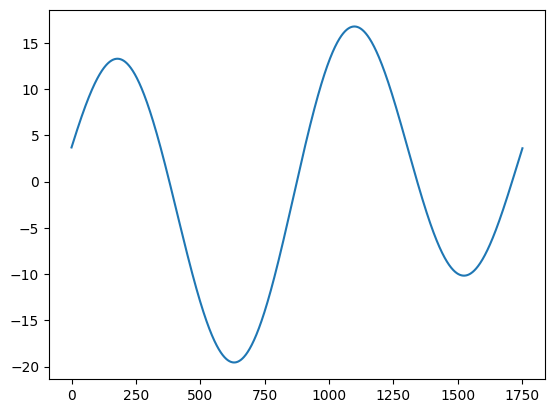

In [8]:
filtered_data = bp_filter_signal_chat(test_1, 7,40 , fs=250)
plt.plot(filtered_data[:,0])

1752 17


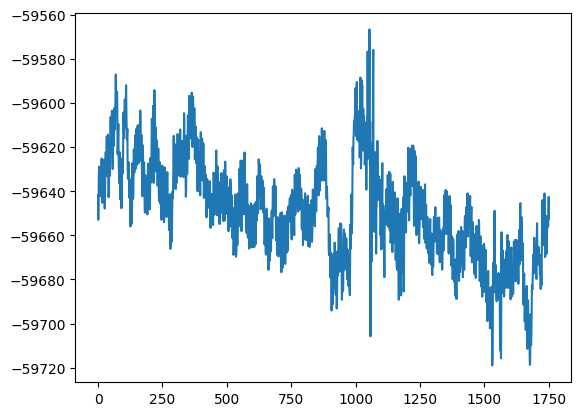

In [9]:
old = bp_filter_signal(test_1, low=0.007, high=40)
plt.plot(old[:,0])

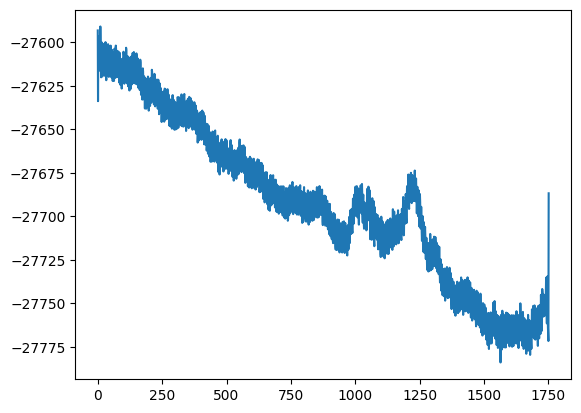

In [10]:
old = bp_filter_signal_fs(test_1, low_hz=7, high_hz=20, fs=250)
plt.plot(old[:,1])

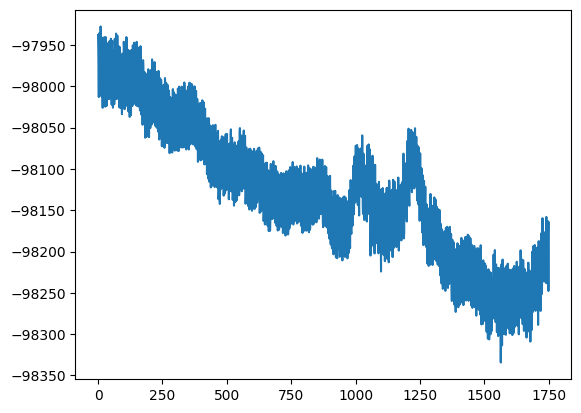

In [11]:
plt.plot(test_1[:,1])

In [7]:
import glob
train_data = glob.glob("/kaggle/input/brain-motor-imagery-classification/train/train/*data_time_series.npy") 

In [8]:
from scipy.signal import welch,iirnotch,filtfilt

In [9]:
def notch_filter(data, freq, fs=250, quality=30):
    nyquist = 0.5 * fs
    notch_freq = freq / nyquist
    b, a = iirnotch(notch_freq, quality)
    y = filtfilt(b, a, data, axis=0)
    return y

In [10]:
def threshold_cul(data):
    """
    Clears outliers from the data based on the interquartile range (IQR) method.
    
    Parameters:
        data (numpy.ndarray or list): Input data.
    
    Returns:
        numpy.ndarray: Cleaned data without outliers.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    # Calculate upper and lower bounds for outlier detection
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr

    return upper_bound, lower_bound

In [ ]:
#%pip install librosa

In [18]:
def save_signal_image(freqs, psd, filename):
    plt.figure(figsize=(8, 8))
    plt.imshow((freqs,psd),cmap='jet', aspect='auto')
    plt.axis('off')
    plt.savefig(filename)
    #plt.show()
    plt.close()

In [12]:
os.makedirs('/kaggle/working/data/120', exist_ok=True)
os.makedirs('/kaggle/working/data/110', exist_ok=True)
os.makedirs('/kaggle/working/data/150', exist_ok=True)

def create_segments(specfic_data=None):
    gabage = 0
    if not specfic_data:
        random1 = random.choice(train_data)
    else:
        random1 = specfic_data

    time_stamps_path = random1.replace("data_time_series.npy", "label_time_stamps.npy")
    time_stamps = np.load(time_stamps_path)

    data_time_stamps_path = random1.replace("data_time_series.npy", "data_time_stamps.npy")
    data_time_stamps = np.load(data_time_stamps_path)

    data_labels_series_path = random1.replace("data_time_series.npy", "label_time_series.npy")
    data_labels_series = np.load(data_labels_series_path)
    name = os.path.basename(random1).split("_data_time_series")[0]
    data = np.load(random1)
    segment_list = []
    for idx, (each, label) in enumerate(zip(time_stamps, data_labels_series)):
        start_time = each
        if idx != len(time_stamps) - 1:
            end_time = time_stamps[idx + 1]
        else:
            end_time = start_time + 7.0
        
        segment_data = data[(data_time_stamps >= start_time+2) & (data_time_stamps < end_time-2), :8]
        #segment_time_stamps = data_time_stamps[(data_time_stamps >= start_time + 2) & (data_time_stamps < end_time - 2)]
        if segment_data.shape[0] <= 700 or segment_data.shape[0] >= 800:
            gabage+=1
            continue  # Skip if no data in the segment 
        segment_data = bp_filter_signal_fs((segment_data), low_hz=7, high_hz=40, fs=250)
        
        segment_data = np.mean(np.abs(segment_data), axis=1)
        segment_data = notch_filter(segment_data, freq=50, fs=250, quality=30)
        #print(segment_data.shape)
        freqs, psd = welch(segment_data, fs=250, nperseg=1024)
        upper_bound, lower_bound =threshold_cul(psd)
        #print(upper_bound, lower_bound)
        psd = np.where(psd > upper_bound, upper_bound, psd)
        psd = np.where(psd < lower_bound, lower_bound, psd)
        psd = np.log1p(psd+1)
        segment_list.append({"freqs": freqs, "psd": psd})
        
        #segment_list.append({"data": segment_data, "label": label})
        stacked_data = np.column_stack((freqs, psd))
        #np.save(f"./data/{label[0]}/{name}_segment_{idx}.npy", stacked_data)
        save_signal_image(freqs, psd, f"./data/{label[0]}/{name}_segment_{idx}.png")
    #print(f"Segments have been processed.gabage {gabage}")
    return segment_list

In [19]:
# os.makedirs('/kaggle/working/data_120', exist_ok=True)
# os.makedirs('/kaggle/working/data_110', exist_ok=True)
# os.makedirs('/kaggle/working/data_150', exist_ok=True)

# def create_segments(specfic_data=None):
#     gabage = 0
#     if not specfic_data:
#         random1 = random.choice(train_data)
#     else:
#         random1 = specfic_data

#     time_stamps_path = random1.replace("data_time_series.npy", "label_time_stamps.npy")
#     time_stamps = np.load(time_stamps_path)

#     data_time_stamps_path = random1.replace("data_time_series.npy", "data_time_stamps.npy")
#     data_time_stamps = np.load(data_time_stamps_path)

#     data_labels_series_path = random1.replace("data_time_series.npy", "label_time_series.npy")
#     data_labels_series = np.load(data_labels_series_path)
#     name = os.path.basename(random1).split("_data_time_series")[0]
#     data = np.load(random1)
#     segment_list = []
#     for idx, (each, label) in enumerate(zip(time_stamps, data_labels_series)):
#         start_time = each
#         if idx != len(time_stamps) - 1:
#             end_time = time_stamps[idx + 1]
#         else:
#             end_time = start_time + 7.0
        
#         segment_data = data[(data_time_stamps >= start_time+2) & (data_time_stamps < end_time-2), :8]
#         #segment_time_stamps = data_time_stamps[(data_time_stamps >= start_time + 2) & (data_time_stamps < end_time - 2)]
#         if segment_data.shape[0] <= 700 or segment_data.shape[0] >= 800:
#             gabage+=1
#             continue  # Skip if no data in the segment 
#         segment_data = bp_filter_signal_fs((segment_data), low_hz=7, high_hz=40, fs=250)
        
#         segment_data = np.mean(np.abs(segment_data), axis=1)
#         D = np.abs(librosa.stft(segment_data))**2
#         S = librosa.feature.melspectrogram(S=D, sr=250,n_mels=segment_data.shape[0])
#         #segment_data = notch_filter(segment_data, freq=120, fs=250, quality=30)
#         #print(segment_data.shape)
#         #freqs, psd = welch(segment_data, fs=250, nperseg=1024)
#         #upper_bound, lower_bound =threshold_cul(psd)
#         #print(upper_bound, lower_bound)
#         #psd = np.where(psd > upper_bound, upper_bound, psd)
#         #psd = np.where(psd < lower_bound, lower_bound, psd)
#         #psd = np.log1p(psd+1)
#         segment_list.append(S)
        
#         #segment_list.append({"data": segment_data, "label": label})
#         #stacked_data = np.column_stack((freqs, psd))
#         np.save(f"./data_{label[0]}/{name}_segment_{idx}.npy", S)
#     #print(f"Segments have been processed.gabage {gabage}")
#     return segment_list

In [20]:
test_2 = create_segments("/kaggle/input/brain-motor-imagery-classification/train/train/s1_d2_p002_002_data_time_series.npy")

/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 746, using nperseg = 746
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 748, using nperseg = 748
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 744, using nperseg = 744
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 747, using nperseg = 747
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 i

In [ ]:
# fig, ax = plt.subplots()
# y, sr = librosa.load(librosa.ex('trumpet'))
# D = np.abs(librosa.stft(y))**2
# S = librosa.feature.melspectrogram(S=D, sr=sr)
# S_dB = librosa.power_to_db(S, ref=np.max)
# img = librosa.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=sr, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')

In [ ]:
# fig, ax = plt.subplots()
# S_dB = librosa.power_to_db(test_2[0], ref=np.max)
# img = librosa.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=250, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')

In [ ]:
plt.plot(test_2[0]["freqs"],test_2[0]["psd"])

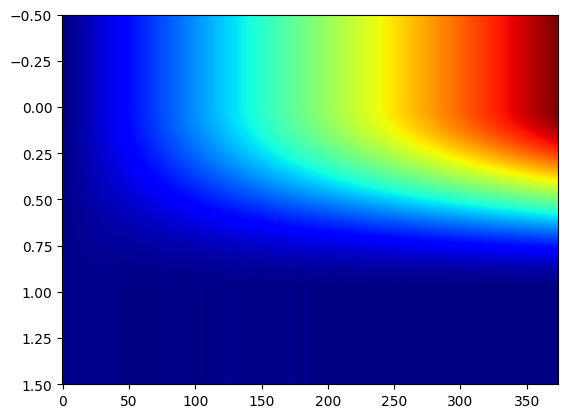

In [24]:
plt.imshow((test_2[0]["freqs"],test_2[0]["psd"]),cmap='jet', aspect='auto')

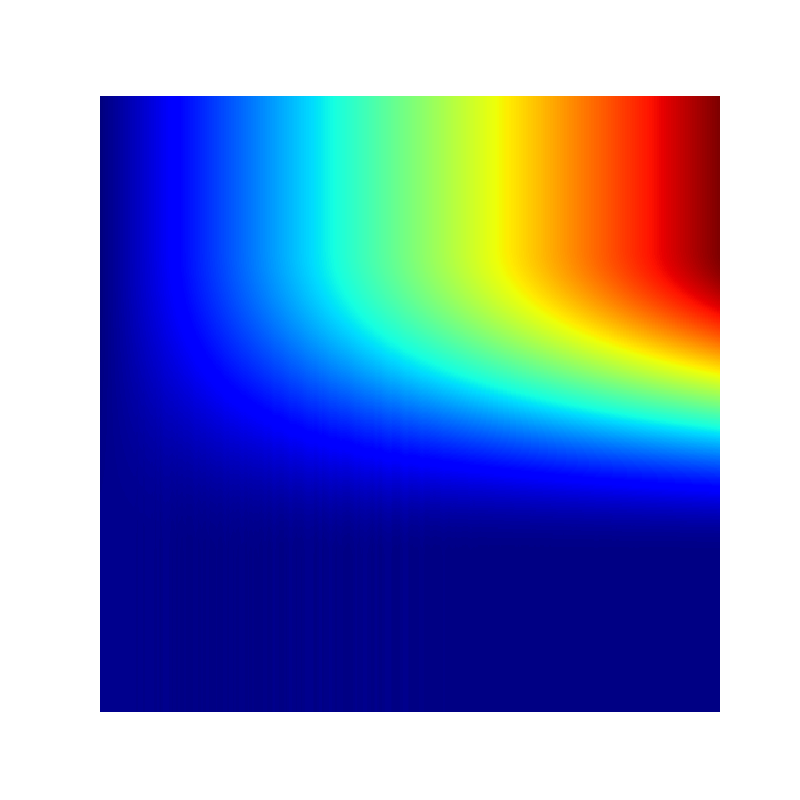

In [31]:
from PIL import Image
Image.open("/kaggle/working/test.png")

In [ ]:
save_signal_image(test_2[0]["freqs"], test_2[0]["psd"], "/kaggle/working/test.png")

In [ ]:
plt.plot(test_2[0]["freqs"],test_2[0]["psd"])

In [14]:
os.makedirs('/kaggle/working/data_test', exist_ok=True)
def create_segments_test(specfic_data):

    random1 = specfic_data

    name = os.path.basename(random1).replace(".npy","")
    data = np.load(random1)
    range_data = data.shape[0]//7
    segment_data = data[range_data*2:range_data*5, :8]
    segment_data = bp_filter_signal_fs((segment_data), low_hz=7, high_hz=40, fs=250)
    segment_data = np.mean(np.abs(segment_data), axis=1)
    segment_data = notch_filter(segment_data, freq=50, fs=250, quality=30)
    #print(segment_data.shape)
    freqs, psd = welch(segment_data, fs=250, nperseg=1024)
    upper_bound, lower_bound =threshold_cul(psd)
    #print(upper_bound, lower_bound)
    psd = np.where(psd > upper_bound, upper_bound, psd)
    psd = np.where(psd < lower_bound, lower_bound, psd)
    psd = np.log1p(psd+1)
    stacked_data = np.column_stack((freqs, psd))
    save_signal_image(freqs, psd, f"./data_test/{name}.png")
    #np.save(f"./data_test/{name}.npy", stacked_data)

In [15]:
test_dataset = glob.glob("/kaggle/input/brain-motor-imagery-classification/test/*")
train_dataset = glob.glob("/kaggle/input/brain-motor-imagery-classification/train/train/*data_time_series.npy")

In [ ]:
len(test_dataset)

In [19]:
for each in tqdm(test_dataset):
    create_segments_test(each)

  0%|          | 0/480 [00:00<?, ?it/s]

In [20]:
for each in tqdm(train_dataset):
    create_segments(each)

  0%|          | 0/191 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 748, using nperseg = 748
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 753, using nperseg = 753
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 752, using nperseg = 752
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 is greater than input length  = 749, using nperseg = 749
  warnings.warn('nperseg = {0:d} is greater than input length '
/opt/conda/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1024 i

In [22]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/data_test/ (stored 0%)
  adding: kaggle/working/data_test/15757717-67ea-4dab-9985-cde3de170bd4.png (deflated 13%)
  adding: kaggle/working/data_test/d1de75f2-cd81-439d-a51f-0069d40ab400.png (deflated 13%)
  adding: kaggle/working/data_test/ab3c9de6-e219-4744-90f7-b0122f27ad41.png (deflated 13%)
  adding: kaggle/working/data_test/d4461f09-14d7-4a6b-9441-8aa73ba1dd6e.png (deflated 13%)
  adding: kaggle/working/data_test/ae0370b5-990f-489f-a1f4-733122120eca.png (deflated 13%)
  adding: kaggle/working/data_test/7b209881-a1dd-4aa3-a06a-037908b07bfa.png (deflated 13%)
  adding: kaggle/working/data_test/28140467-d600-4b8f-b70b-5a85bb1706cf.png (deflated 13%)
  adding: kaggle/working/data_test/0d3c199b-7a7b-4bac-a2b7-19ed2e81c8b0.png (deflated 13%)
  adding: kaggle/working/data_test/7141138f-5796-4a32-a5f4-684ecf9e3a3e.png (deflated 13%)
  adding: kaggle/working/data_test/ccf

In [ ]:
sample_img = np.load("/kaggle/working/data_110/s1_d2_p002_005_segment_29.npy")
#sample_img = np.transpose(sample_img)
filter_img = np.abs(sample_img)

In [ ]:
sample_data120 = np.load("/kaggle/working/data_120/s2_d2_p007_001_segment_16.npy")
sample_data150 = np.load("/kaggle/working/data_150/s1_d2_p010_008_segment_20.npy")

In [ ]:
plt.semilogy(sample_img[:, 0], sample_img[:, 1])
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Title of the Plot')
plt.savefig('plot.png')
plt.show()

In [ ]:
# Sample data
x = sample_img[:, 0]
y = sample_img[:, 1]

# Set the style
plt.style.use('seaborn-darkgrid')

# Create a larger figure
plt.figure(figsize=(15, 5))

# Plot data
plt.semilogy(x, y, linestyle='-')

# Save and show
#plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from PIL import Image
Image.open("/kaggle/working/plot.png")

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np

# Get the file paths for each class
data_110 = glob.glob("/kaggle/working/data_110/*")
data_120 = glob.glob("/kaggle/working/data_120/*")
data_150 = glob.glob("/kaggle/working/data_150/*")
data_test = glob.glob("/kaggle/working/data_test/*")
for i in range(20):
    sample_110 = np.load(data_110[i])
    sample_120 = np.load(data_120[i])
    sample_150 = np.load(data_150[i])
    samole_test = np.load(data_test[i])
    # Plot a sample from each class
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow((sample_110[:, 0],sample_110[:, 1]), cmap='jet', aspect='auto')
    plt.title('Data_110')

    plt.subplot(1, 4, 2)
    plt.imshow((sample_120[:, 0], sample_120[:, 1]), cmap='jet', aspect='auto')
    plt.title('Data_120')

    plt.subplot(1, 4, 3)
    plt.imshow((sample_150[:, 0], sample_150[:, 1]), cmap='jet', aspect='auto')
    plt.title('Data_150')
    
    plt.subplot(1, 4, 4)
    plt.imshow((samole_test[:, 0], samole_test[:, 1]), cmap='jet', aspect='auto')
    plt.title('Data_test')
    
    plt.show()

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np

# Get the file paths for each class
data_110 = glob.glob("/kaggle/working/data_110/*")
data_120 = glob.glob("/kaggle/working/data_120/*")
data_150 = glob.glob("/kaggle/working/data_150/*")
data_test = glob.glob("/kaggle/working/data_test/*")
for i in range(20):
    sample_110 = np.load(data_110[i])
    sample_120 = np.load(data_120[i])
    sample_150 = np.load(data_150[i])
    samole_test = np.load(data_test[i])
    # Plot a sample from each class
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.plot(sample_110[:, 0], sample_110[:, 1])
    plt.title('Data_110')

    plt.subplot(1, 4, 2)
    plt.plot(sample_120[:, 0], sample_120[:, 1])
    plt.title('Data_120')

    plt.subplot(1, 4, 3)
    plt.plot(sample_150[:, 0], sample_150[:, 1])
    plt.title('Data_150')
    
    plt.subplot(1, 4, 4)
    plt.plot(samole_test[:, 0], samole_test[:, 1])
    plt.title('Data_test')
    
    plt.show()

In [ ]:
import cv2
from PIL import Image
# Example function to create and save a plot as an image
# def save_signal_image(freqs, psd, filename):
#     plt.figure(figsize=(8, 8))
#     plt.plot(freqs, psd)
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Power Spectral Density')
#     plt.title('Frequency Spectrum')
#     #plt.savefig(filename)
#     plt.close()

# Generate an example plot
# freqs = test_2[0]["freqs"]
# psd = test_2[0]["psd"]
# save_signal_image(freqs, psd, '/mnt/data/signal_image.png')

# Load the image
image = Image.open('signal_image.png')

# Resize the image to 224x224 pixels (ViT input size)
image_resized = image.resize((224, 224))

# Convert the image to RGB (if it is grayscale)
if image_resized.mode != 'RGB':
    image_resized = image_resized.convert('RGB')

# Convert the image to a numpy array
image_array = np.array(image_resized)

# Normalize the pixel values to [0, 1]
image_array = image_array / 255.0

# If needed, add batch dimension
image_array = np.expand_dims(image_array, axis=0)

print("Image shape:", image_array.shape)  # Should be (1, 224, 224, 3)

# Now, image_array is ready to be used as input to a ViT model

In [ ]:
image

In [ ]:
image_resized

In [ ]:
import cv2

# Example function to create and save a plot as an image
def save_signal_image(freqs, psd, filename):
    plt.figure(figsize=(10, 10))
    plt.plot(freqs, psd)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.title('Frequency Spectrum')
    plt.savefig(filename)
    plt.axis('off')
    plt.show()
    #plt.close()

In [ ]:
save_signal_image(test_2[0]["freqs"], test_2[0]["psd"], 'signal_image.png')

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np

# Get the file paths for each class
data_110 = glob.glob("/kaggle/working/data_110/*")
data_120 = glob.glob("/kaggle/working/data_120/*")
data_150 = glob.glob("/kaggle/working/data_150/*")
data_test = glob.glob("/kaggle/working/data_test/*")
for i in range(20):
    sample_110 = np.load(data_110[i])
    sample_120 = np.load(data_120[i])
    sample_150 = np.load(data_150[i])
    samole_test = np.load(data_test[i])
    # Plot a sample from each class
    plt.figure(figsize=(15, 5))
    
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(test_2[0], ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=250, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    
    plt.subplot(1, 4, 1)
    plt.plot(sample_110[:, 0], sample_110[:, 1])
    plt.title('Data_110')

    plt.subplot(1, 4, 2)
    plt.plot(sample_120[:, 0], sample_120[:, 1])
    plt.title('Data_120')

    plt.subplot(1, 4, 3)
    plt.plot(sample_150[:, 0], sample_150[:, 1])
    plt.title('Data_150')
    
    plt.subplot(1, 4, 4)
    plt.plot(samole_test[:, 0], samole_test[:, 1])
    plt.title('Data_test')
    
    plt.show()

# Train

In [3]:
transforms = {
    "train": T.Compose([
        T.Resize((384, 384), interpolation=T.InterpolationMode.LANCZOS),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((384, 384), interpolation=T.InterpolationMode.LANCZOS),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}

In [4]:
device = torch.device("cuda")
#maxvit_xlarge_tf_384
model_name = "hf_hub:timm/maxvit_base_tf_384.in1k" 

In [32]:
num_epochs = 5
k_folds = 2
batch_size = 4
num_accumulate = 16
criterion = nn.CrossEntropyLoss()
metric = evaluate.load("f1")
SEED = 37
kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)
num_classes = 3

In [7]:
dataset = ImageDataset("/kaggle/input/image-signal/kaggle/working/data", transform=transforms["train"])

In [8]:
os.makedirs("/kaggle/working/models", exist_ok=True)

In [33]:
all_best_eval_for_weight = []
torch.cuda.empty_cache()
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    model = timm.create_model(model_name, pretrained=True, num_classes=7).to(device)
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-4)
    optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=3)                           
    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)

    max_val = 0
    statVisual = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
    }
    for epoch in range(num_epochs):
        train_loss_epoch = []
        train_preds = []
        train_targets = []
        num_updates = epoch * len(train_dataloader)

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()

            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()
    
        optimizer.sync_lookahead()              
        scheduler.step(epoch + 1)
        
        val_loss_epoch = []
        val_preds = []
        val_targets = []
        
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
    
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()

        metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
        metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]
        
        statVisual["metric_train"].append(metric_train)
        statVisual["metric_val"].append(metric_val)
    
        statVisual["train_loss"].append(np.average(train_loss_epoch))
        statVisual["val_loss"].append(np.average(val_loss_epoch))
        
        if metric_val > max_val:
            max_val = metric_val
            torch.save(model, f"/kaggle/working/models/checkpoint_fold{fold}.pt")
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot F1 Score (Train vs. Validation)
    axs[0].plot(statVisual["metric_train"], label='Train F1 Score')
    axs[0].plot(statVisual["metric_val"], label='Validation F1 Score')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('F1 Score')
    axs[0].set_title('F1 Score (Train vs. Validation)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Loss (Train vs. Validation)
    axs[1].plot(statVisual["train_loss"], label='Train Loss')
    axs[1].plot(statVisual["val_loss"], label='Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss (Train vs. Validation)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()  
    plt.show()
    all_best_eval_for_weight.append(max_val)

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

AssertionError: Torch not compiled with CUDA enabled

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Epoch: 0 | Metric: 0.16622922134733162 | Training Loss: 1.102876226974887 | Validation Loss: 1.100727489778212


  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Epoch: 1 | Metric: 0.17303128371089538 | Training Loss: 1.1007627093115229 | Validation Loss: 1.098174371919432


  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Epoch: 2 | Metric: 0.25176913705517073 | Training Loss: 1.1001786428768041 | Validation Loss: 1.0989702423135717


  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Epoch: 3 | Metric: 0.16058394160583941 | Training Loss: 1.0989706898360274 | Validation Loss: 1.1004580767838272


  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

Epoch: 4 | Metric: 0.33789494159301103 | Training Loss: 1.0986337334828606 | Validation Loss: 1.0984235735206338


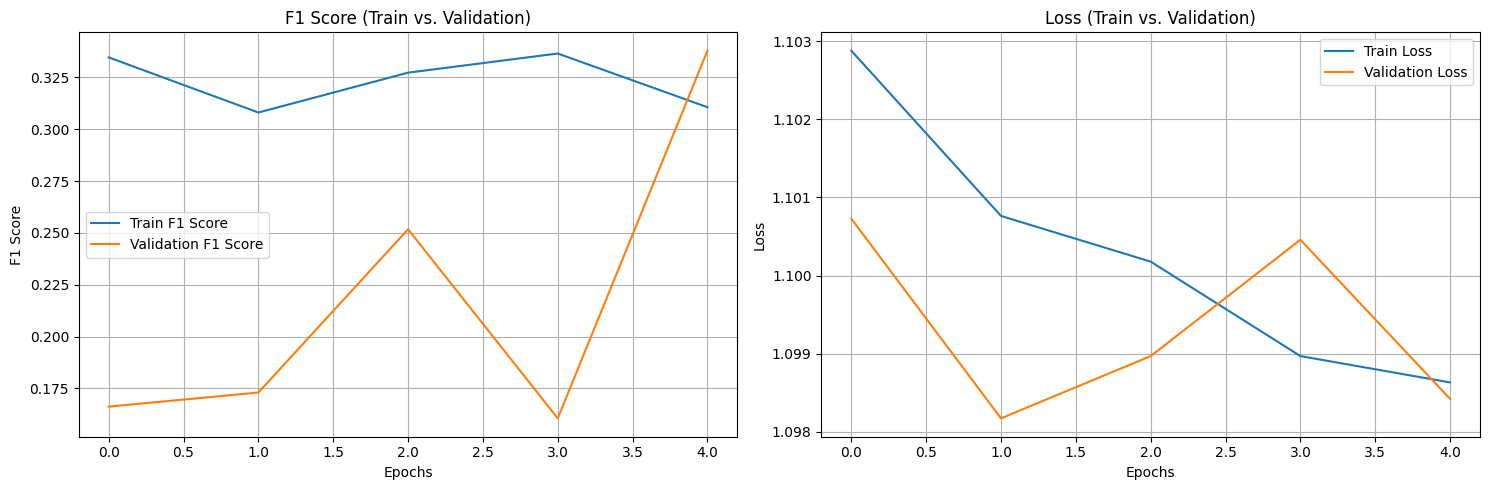

NameError: name 'all_best_eval_for_weight' is not defined

In [34]:
device = "cuda"
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)
optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-4)
optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=3)                           
scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

np.random.seed(SEED)
num_samples = len(dataset)
indices = np.random.permutation(num_samples)
val_size = int(num_samples * 0.2)
train_size = num_samples - val_size
train_idx, val_idx = indices[:train_size], indices[train_size:]

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)

max_val = 0
statVisual = {
    "metric_train": [],
    "metric_val": [],
    "train_loss": [],
    "val_loss": [],
}
for epoch in range(num_epochs):
    train_loss_epoch = []
    train_preds = []
    train_targets = []
    num_updates = epoch * len(train_dataloader)

    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader)):
        inputs, targets = batch
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()

        if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
            optimizer.step()
            scheduler.step_update(num_updates=num_updates)
            optimizer.zero_grad()

        train_loss_epoch.append(loss.item())
        train_preds += outputs.argmax(-1).detach().cpu().tolist()
        train_targets += targets.tolist()

    optimizer.sync_lookahead()              
    scheduler.step(epoch + 1)

    val_loss_epoch = []
    val_preds = []
    val_targets = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))

            val_loss_epoch.append(loss.item())
            val_preds += outputs.argmax(-1).detach().cpu().tolist()
            val_targets += targets.tolist()

    metric_train = metric.compute(predictions=train_preds, references=train_targets, average="macro")["f1"]
    metric_val = metric.compute(predictions=val_preds, references=val_targets, average="macro")["f1"]

    statVisual["metric_train"].append(metric_train)
    statVisual["metric_val"].append(metric_val)

    statVisual["train_loss"].append(np.average(train_loss_epoch))
    statVisual["val_loss"].append(np.average(val_loss_epoch))

    if metric_val > max_val:
        max_val = metric_val
        torch.save(model, f"/kaggle/working/models/checkpoint_{epoch}.pt")
    print(f"Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot F1 Score (Train vs. Validation)
axs[0].plot(statVisual["metric_train"], label='Train F1 Score')
axs[0].plot(statVisual["metric_val"], label='Validation F1 Score')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('F1 Score')
axs[0].set_title('F1 Score (Train vs. Validation)')
axs[0].legend()
axs[0].grid(True)

# Plot Loss (Train vs. Validation)
axs[1].plot(statVisual["train_loss"], label='Train Loss')
axs[1].plot(statVisual["val_loss"], label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss (Train vs. Validation)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()  
plt.show()
all_best_eval_for_weight.append(max_val)

In [35]:
sample_summission = pd.read_csv("/kaggle/input/brain-motor-imagery-classification/sample_submission.csv")

In [36]:
sample_summission

,id,predict
0,a0dfb1f6-a76b-404f-a04a-b61e955ce1ef,110.0
1,51afd110-7556-4a7d-b6d2-68e46256f267,150.0
2,eb229854-1a14-4e1f-8e52-470edbec47c9,150.0
3,8fa74efe-f269-415e-a968-1a92e7c66fe6,NaN
4,7b209881-a1dd-4aa3-a06a-037908b07bfa,NaN
...,...,...
475,69e84db3-0019-4e38-90fc-968f45747a16,NaN
476,d18d7d80-78fa-402a-ba1c-e35d72382b18,NaN
477,0a532391-dd42-413f-ab15-798960de95d6,NaN
478,0c02ad4f-de15-48cb-ad31-0925e69bfe97,NaN


In [38]:
output_dir_test = "/kaggle/input/image-signal/kaggle/working/data_test"

In [39]:
answers_final = dict()
vote = []

loaded_model = torch.load(f"/kaggle/working/models/checkpoint_4.pt")
model.eval() 
with torch.no_grad():
    for file_name in tqdm(sample_summission["id"]):
        img_path = os.path.join(output_dir_test,file_name)+".png"
        img = Image.open(img_path).convert("RGB")
        transformed = transforms["test"](img).unsqueeze(0).to(device)
        if fold == 0:
            answers_final[file_name] = [loaded_model(transformed).argmax(-1).item()]
        else:
            answers_final[file_name].append(loaded_model(transformed).argmax(-1).item())
for key in answers_final:
    vote.append(stats.mode(answers_final[key])[0])

  0%|          | 0/480 [00:00<?, ?it/s]

In [45]:
vote.count(0)

480

# ERD

In [46]:
import mne
from mne.time_frequency import tfr_multitaper

In [47]:
eeg_data = np.load('/kaggle/input/brain-motor-imagery-classification/train/train/s1_d2_p002_002_data_time_series.npy')

In [50]:
eeg_data.shape

(53714, 17)

In [51]:
time_stamp = np.load("/kaggle/input/brain-motor-imagery-classification/train/train/s1_d2_p002_002_data_time_stamps.npy")

In [54]:
time_stamp

array([61679.01362649, 61679.01764724, 61679.02166798, ...,
       61894.97194118, 61894.97596193, 61894.97998268])

In [55]:
label_time_series = np.load("/kaggle/input/brain-motor-imagery-classification/train/train/s1_d2_p002_002_label_time_series.npy")

In [57]:
label_time_stamp = np.load("/kaggle/input/brain-motor-imagery-classification/train/train/s1_d2_p002_002_label_time_stamps.npy")

In [177]:
event_list = []
c = 0
for label,time in zip(label_time_series,label_time_stamp):
    event_list.append([c, 0, label[0]])
    c+=7

In [178]:
eeg_data = np.load("/kaggle/input/brain-motor-imagery-classification/train/train/s1_d2_p002_002_data_time_series.npy")

In [179]:
eeg_data = eeg_data[:,[1,3]]

In [180]:
eeg_data.shape

(53714, 2)

In [181]:
eeg_data = eeg_data.T

In [182]:
eeg_data.shape

(2, 53714)

In [183]:
event_list

[[0, 0, 120],
 [7, 0, 110],
 [14, 0, 150],
 [21, 0, 150],
 [28, 0, 120],
 [35, 0, 110],
 [42, 0, 120],
 [49, 0, 110],
 [56, 0, 150],
 [63, 0, 150],
 [70, 0, 120],
 [77, 0, 110],
 [84, 0, 120],
 [91, 0, 150],
 [98, 0, 110],
 [105, 0, 150],
 [112, 0, 120],
 [119, 0, 110],
 [126, 0, 120],
 [133, 0, 110],
 [140, 0, 150],
 [147, 0, 150],
 [154, 0, 120],
 [161, 0, 110],
 [168, 0, 150],
 [175, 0, 120],
 [182, 0, 110],
 [189, 0, 150],
 [196, 0, 120],
 [203, 0, 110]]

In [184]:
events[:, 0] = (events[:, 0] * sfreq).astype(int)

In [121]:
print("Event list:", events)
print("Event IDs:", event_id)

Event list: [[61686     0   120]
 [61693     0   110]
 [61700     0   150]
 [61707     0   150]
 [61714     0   120]
 [61721     0   110]
 [61728     0   120]
 [61735     0   110]
 [61742     0   150]
 [61749     0   150]
 [61756     0   120]
 [61763     0   110]
 [61770     0   120]
 [61777     0   150]
 [61784     0   110]
 [61791     0   150]
 [61798     0   120]
 [61805     0   110]
 [61812     0   120]
 [61819     0   110]
 [61826     0   150]
 [61833     0   150]
 [61840     0   120]
 [61846     0   110]
 [61854     0   150]
 [61860     0   120]
 [61867     0   110]
 [61874     0   150]
 [61881     0   120]
 [61888     0   110]]
Event IDs: {'left': 110, 'right': 120, 'rest': 150}


In [144]:
eeg_data

array([[-139471.31, -139561.8 , -139160.98, ..., -143665.39, -143772.6 ,
        -143414.7 ],
       [-154886.69, -154901.34, -154696.61, ..., -160029.2 , -160056.02,
        -159881.67]], dtype=float32)

In [185]:
events = np.array(event_list, dtype='int32') #[[time_series,0,label],...]
print("_______________________________________")
print("event",events)
print("event shape",events.shape)
print("-------------------------------------")
# Define parameters
sfreq = 250  # Sampling frequency
ch_names = ['C3', 'C4']  # Assuming data contains only these two channels
ch_types = ['eeg', 'eeg']

segment_duration = 1750 / sfreq  


# Create MNE info and Raw object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)
print("----------------------------------------")
print("raw",raw)
print("info",info)
print("eeg_data",eeg_data)
print("eeg_shape",eeg_data.shape)
print("-----------------------------------------")


# Set standard montage for electrode locations
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
print(segment_duration)
# Define event_id and epochs
event_id = {'left': 110, 'right': 120, 'rest': 150}
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=segment_duration, baseline=(0, 0))
print("------------------------------------------------------")
print("epochs",epochs)
print("------------------------------------------------------")
# Compute TFR (time-frequency representation)
freqs = np.arange(8, 31, 1)  # Frequency range
n_cycles = freqs / 2.  # Different number of cycles per frequency
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                       return_itc=False, average=False)
print("------------------------------------------------------")
print("power",power)
print(epochs.drop_log)
print("------------------------------------------------------")

_______________________________________
event [[  0   0 120]
 [  7   0 110]
 [ 14   0 150]
 [ 21   0 150]
 [ 28   0 120]
 [ 35   0 110]
 [ 42   0 120]
 [ 49   0 110]
 [ 56   0 150]
 [ 63   0 150]
 [ 70   0 120]
 [ 77   0 110]
 [ 84   0 120]
 [ 91   0 150]
 [ 98   0 110]
 [105   0 150]
 [112   0 120]
 [119   0 110]
 [126   0 120]
 [133   0 110]
 [140   0 150]
 [147   0 150]
 [154   0 120]
 [161   0 110]
 [168   0 150]
 [175   0 120]
 [182   0 110]
 [189   0 150]
 [196   0 120]
 [203   0 110]]
event shape (30, 3)
-------------------------------------
Creating RawArray with float64 data, n_channels=2, n_times=53714
    Range : 0 ... 53713 =      0.000 ...   214.852 secs
Ready.
----------------------------------------
raw <RawArray | 2 x 53714 (214.9 s), ~847 kB, data loaded>
info <Info | 7 non-empty values
 bads: []
 ch_names: C3, C4
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 250.0 Hz
>
eeg_data [[-13947

In [175]:
# Average power over epochs
left_power = power['left'].average()
right_power = power['right'].average()
rest_power = power['rest'].average()

# Compute ERD/ERS
baseline = (None, 0)  # Baseline period (from the start to the event)
left_power.apply_baseline(baseline, mode='percent')
right_power.apply_baseline(baseline, mode='percent')
rest_power.apply_baseline(baseline, mode='percent')

#Plotting
def plot_erd_ers(power, ch_name, times, title):
    plt.figure(figsize=(10, 5))
    print("8-12",power.data[power.ch_names.index(ch_name), 8:12])
    print("14-30",power.data[power.ch_names.index(ch_name), 14:30])
    plt.plot(times, power.data[power.ch_names.index(ch_name), 8:12].mean(axis=0), label='8-12Hz')
    plt.plot(times, power.data[power.ch_names.index(ch_name), 14:30].mean(axis=0), label='14-30Hz')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('ERD/ERS (%)')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot ERD/ERS for C3 and C4 for each condition
plot_erd_ers(left_power, 'C3', epochs.times, 'Left Arm Movement (C3)')
plot_erd_ers(left_power, 'C4', epochs.times, 'Left Arm Movement (C4)')
plot_erd_ers(right_power, 'C3', epochs.times, 'Right Arm Movement (C3)')
plot_erd_ers(right_power, 'C4', epochs.times, 'Right Arm Movement (C4)')
plot_erd_ers(rest_power, 'C3', epochs.times, 'Rest (C3)')
plot_erd_ers(rest_power, 'C4', epochs.times, 'Rest (C4)')

# Topographic plot at specific times
times_to_plot = [0.5, 1.5]  # Times to plot
for t in times_to_plot:
    left_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30)
    plt.title(f'Left Arm Movement at {t}s')
    plt.show()

for t in times_to_plot:
    right_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30)
    plt.title(f'Right Arm Movement at {t}s')
    plt.show()

for t in times_to_plot:
    rest_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30)
    plt.title(f'Rest at {t}s')
    plt.show()

ValueError: Baseline interval is only one sample. Use `baseline=(0, 0)` if this is desired.

_______________________________________
event [[  0   0 120]
 [  7   0 110]
 [ 14   0 150]
 [ 21   0 150]
 [ 28   0 120]
 [ 35   0 110]
 [ 42   0 120]
 [ 49   0 110]
 [ 56   0 150]
 [ 63   0 150]
 [ 70   0 120]
 [ 77   0 110]
 [ 84   0 120]
 [ 91   0 150]
 [ 98   0 110]
 [105   0 150]
 [112   0 120]
 [119   0 110]
 [126   0 120]
 [133   0 110]
 [140   0 150]
 [147   0 150]
 [154   0 120]
 [161   0 110]
 [168   0 150]
 [175   0 120]
 [182   0 110]
 [189   0 150]
 [196   0 120]
 [203   0 110]]
event shape (30, 3)
-------------------------------------
Creating RawArray with float64 data, n_channels=2, n_times=53714
    Range : 0 ... 53713 =      0.000 ...   214.852 secs
Ready.
----------------------------------------
raw <RawArray | 2 x 53714 (214.9 s), ~847 kB, data loaded>
info <Info | 7 non-empty values
 bads: []
 ch_names: C3, C4
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 250.0 Hz
>
eeg_data [[-13947

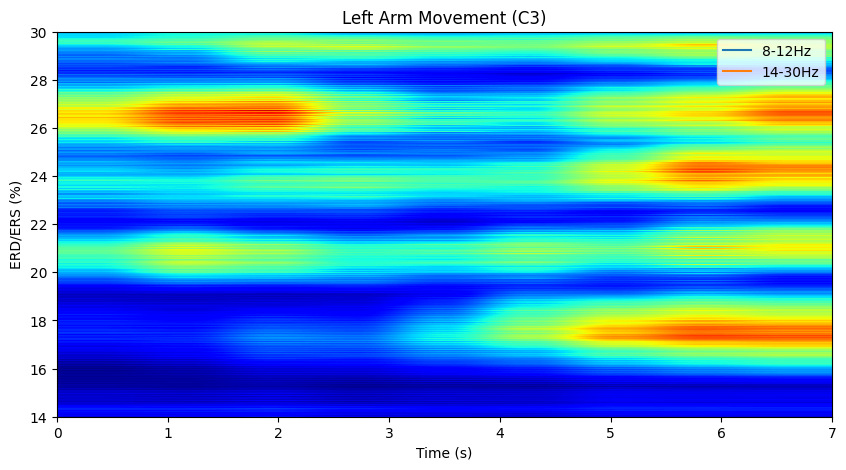

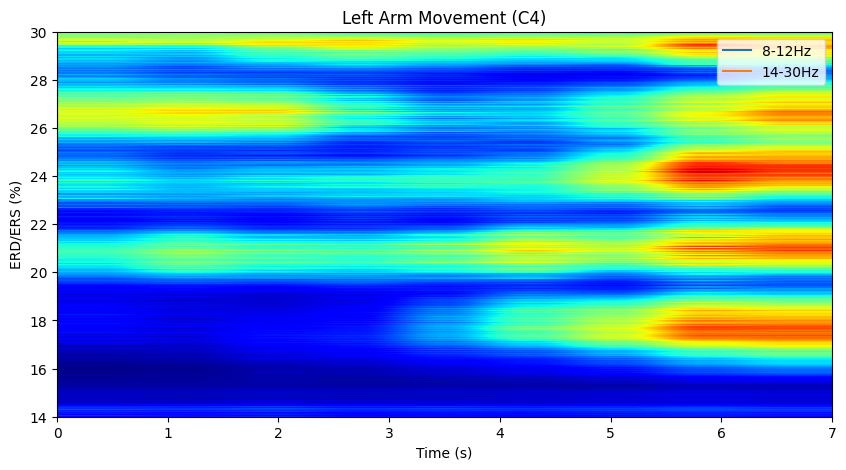

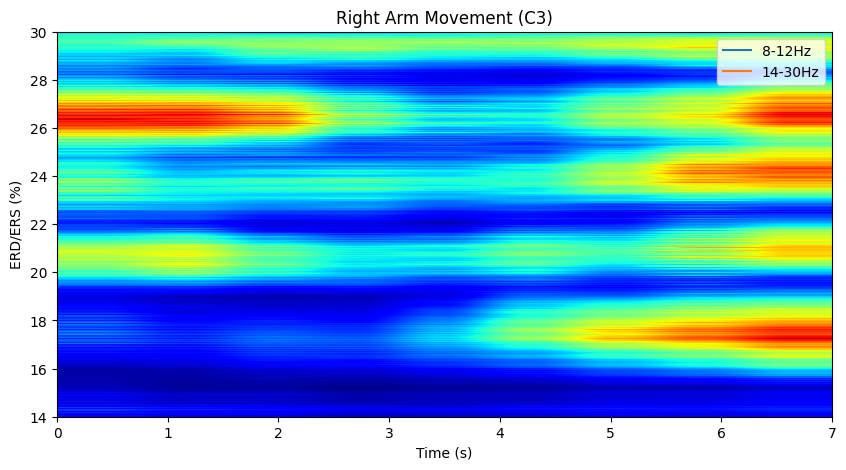

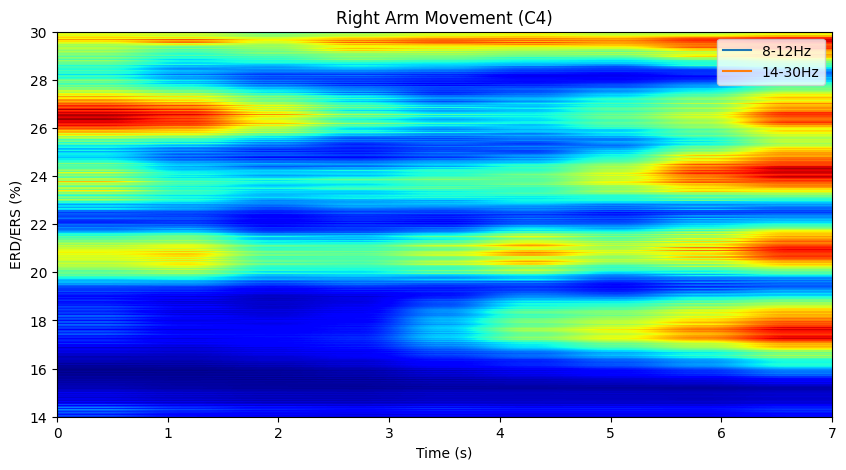

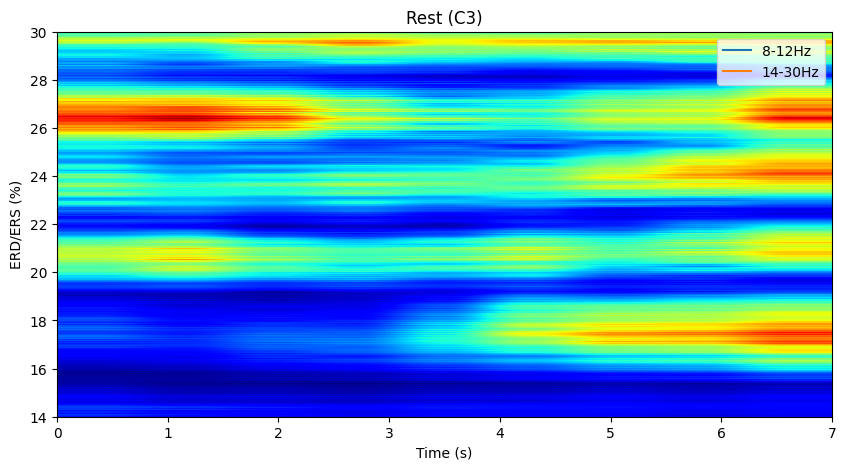

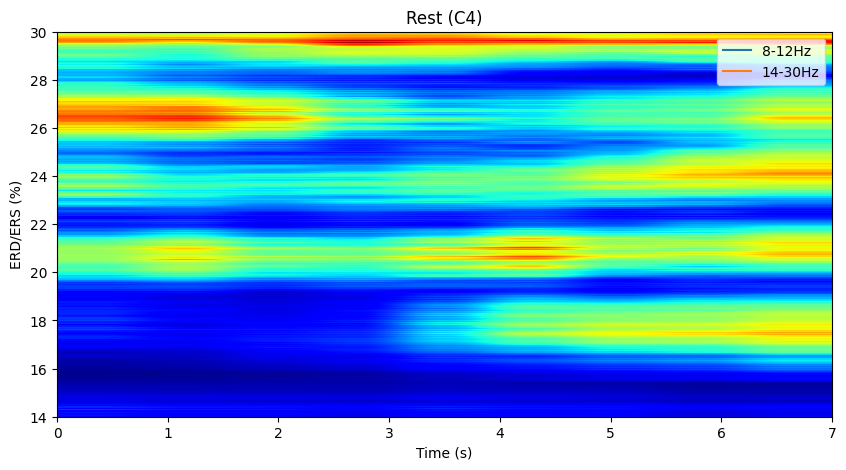

No baseline correction applied


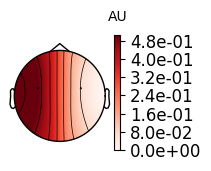

No baseline correction applied


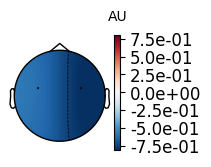

No baseline correction applied


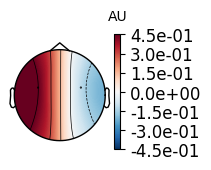

No baseline correction applied


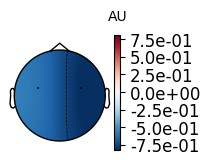

No baseline correction applied


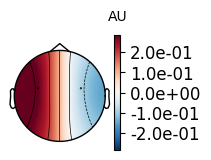

No baseline correction applied


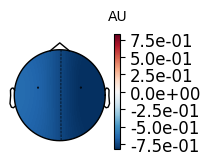

In [203]:

events = np.array(event_list, dtype='int32') #[[time_series,0,label],...]
print("_______________________________________")
print("event",events)
print("event shape",events.shape)
print("-------------------------------------")
# Define parameters
sfreq = 250  # Sampling frequency
ch_names = ['C3', 'C4']  # Assuming data contains only these two channels
ch_types = ['eeg', 'eeg']

segment_duration = 1750 / sfreq  

# Create MNE info and Raw object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)
print("----------------------------------------")
print("raw",raw)
print("info",info)
print("eeg_data",eeg_data)
print("eeg_shape",eeg_data.shape)
print("-----------------------------------------")


# Set standard montage for electrode locations
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
print(segment_duration)
# Define event_id and epochs
event_id = {'left': 110, 'right': 120, 'rest': 150}
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=segment_duration, baseline=(2, 5))
print("------------------------------------------------------")
print("epochs",epochs)
print("------------------------------------------------------")
# Compute TFR (time-frequency representation)
freqs = np.arange(8, 31, 1)  # Frequency range
n_cycles = freqs / 2.  # Different number of cycles per frequency
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                       return_itc=False, average=False)

# Average power over epochs
left_power = power['left'].average()
right_power = power['right'].average()
rest_power = power['rest'].average()

# Compute ERD/ERS
baseline = (0, 0)  # Use only one sample as baseline
left_power.apply_baseline(baseline, mode='percent')
right_power.apply_baseline(baseline, mode='percent')
rest_power.apply_baseline(baseline, mode='percent')

# Plotting
def plot_erd_ers(power, ch_name, times, title):
    plt.figure(figsize=(10, 5))
    plt.plot(times, power.data[power.ch_names.index(ch_name), 8:12].mean(axis=0), label='8-12Hz')
    plt.plot(times, power.data[power.ch_names.index(ch_name), 14:30].mean(axis=0), label='14-30Hz')
    plt.imshow(power.data[power.ch_names.index(ch_name), 8:12].T,cmap='jet',extent=[times[0], times[-1], 8, 30],aspect='auto')
    plt.imshow(power.data[power.ch_names.index(ch_name), 14:30].T,cmap='jet',extent=[times[0], times[-1], 14, 30],aspect='auto')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('ERD/ERS (%)')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot ERD/ERS for C3 and C4 for each condition
plot_erd_ers(left_power, 'C3', epochs.times, 'Left Arm Movement (C3)')
plot_erd_ers(left_power, 'C4', epochs.times, 'Left Arm Movement (C4)')
plot_erd_ers(right_power, 'C3', epochs.times, 'Right Arm Movement (C3)')
plot_erd_ers(right_power, 'C4', epochs.times, 'Right Arm Movement (C4)')
plot_erd_ers(rest_power, 'C3', epochs.times, 'Rest (C3)')
plot_erd_ers(rest_power, 'C4', epochs.times, 'Rest (C4)')

# Topographic plot at specific times
times_to_plot = [2, 6]  # Times to plot
for t in times_to_plot:
    left_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30)

for t in times_to_plot:
    right_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30)

for t in times_to_plot:
    rest_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30)

Creating RawArray with float64 data, n_channels=2, n_times=53714
    Range : 0 ... 53713 =      0.000 ...   214.852 secs
Ready.
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 1751 original time points ...
0 bad epochs dropped
Not setting metadata


AttributeError: 'EpochsTFR' object has no attribute 'plot'

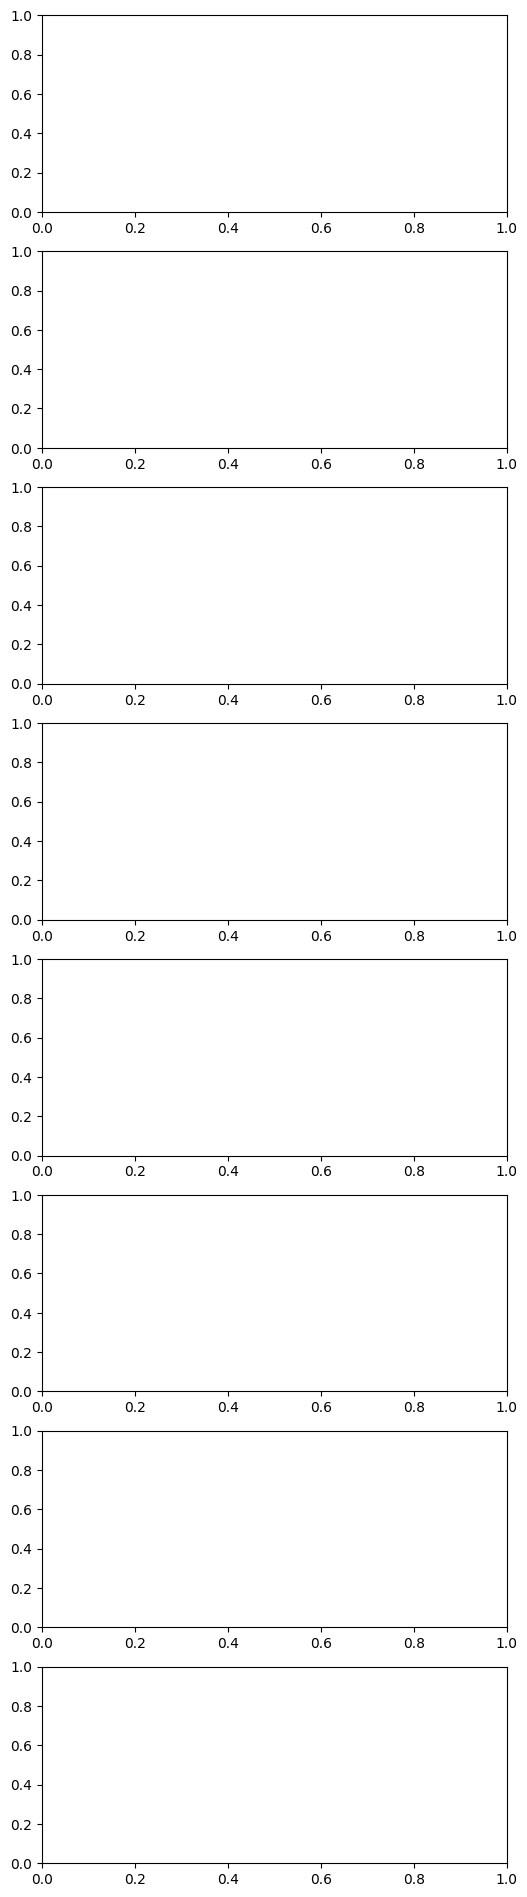

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.time_frequency import tfr_multitaper

# Assuming eeg_data and events are already defined
# events = np.array(event_list, dtype='int32')

# Define parameters
sfreq = 250  # Sampling frequency
ch_names = ['C3', 'C4']  # Assuming data contains only these two channels
ch_types = ['eeg', 'eeg']
segment_duration = 1750 / sfreq  

# Create MNE info and Raw object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# Set standard montage for electrode locations
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Define event_id and epochs
event_id = {'left': 110, 'right': 120, 'rest': 150}
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=segment_duration, baseline=(0, 0))

# Compute TFR (time-frequency representation)
freqs = np.arange(8, 31, 1)  # Frequency range
n_cycles = freqs / 2.  # Different number of cycles per frequency
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, average=False)

# Set the scale limits (vmin and vmax) based on the power data
vmin = np.min(power.data)
vmax = np.max(power.data)

# Create a figure with 8 subplots (2 channels * 3 conditions + 2 extra)
fig, axes = plt.subplots(8, 1, figsize=(6, 24))

# Define the conditions and channel names
conditions = ['left', 'right', 'rest']
channels = ['C3', 'C4']

# Plot the TFR for each condition and channel
for i, condition in enumerate(conditions):
    for j, channel in enumerate(channels):
        idx = i * 2 + j
        power.plot([j], baseline=(0, 0), mode='logratio', vmin=vmin, vmax=vmax, axes=axes[idx], show=False, colorbar=(j == 1))

# Remove axes for all subplots
for ax in axes:
    ax.axis('off')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('combined_tfr.png', bbox_inches='tight', pad_inches=0)
plt.show()

Creating RawArray with float64 data, n_channels=2, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.996 secs
Ready.
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 751 original time points ...
2 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


RuntimeError: No digitization points found.

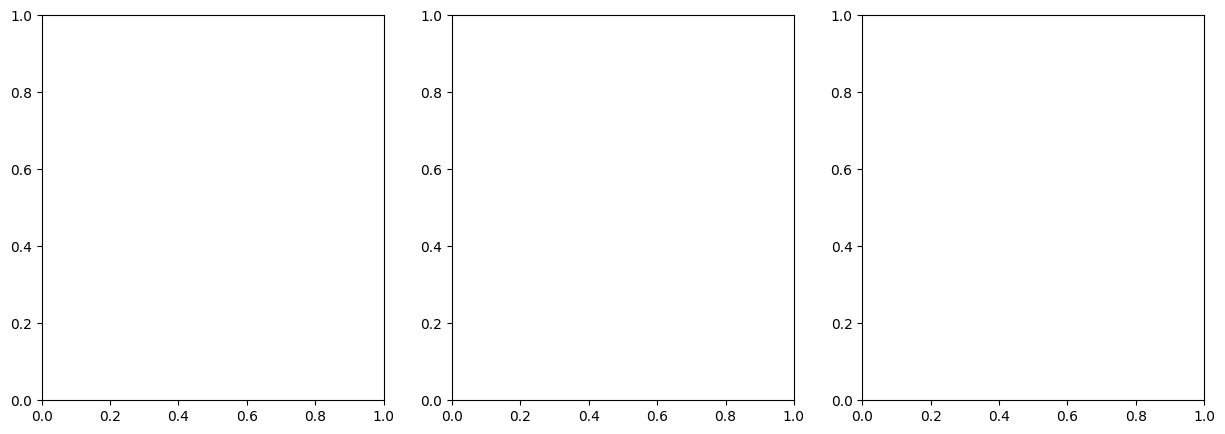

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_multitaper

# Example data for EEG
eeg_data = np.random.randn(2, 1000)  # Two channels, 1000 samples each

# Example event list
event_list = [[100, 0, 1], [300, 0, 2], [500, 0, 3]]  # [time_series, 0, event_code]

# Convert event list to NumPy array
events = np.array(event_list, dtype='int32')

# Define parameters
sfreq = 250  # Sampling frequency
ch_names = ['C3', 'C4']  # Assuming data contains only these two channels
ch_types = ['eeg', 'eeg']

# Create MNE info and Raw object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# Define event_id and epochs
event_id = {'left': 1, 'right': 2, 'rest': 3}  # Mapping event names to codes
epochs = mne.Epochs(raw, events, event_id, tmin=-1, tmax=2, baseline=(-1, 0))

# Compute TFR (time-frequency representation)
freqs = np.arange(8, 31, 1)  # Frequency range
n_cycles = freqs / 2.  # Different number of cycles per frequency
power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                       return_itc=False, average=False)

# Average power over epochs
left_power = power['left'].average()
right_power = power['right'].average()
rest_power = power['rest'].average()

# Compute ERD/ERS
baseline = (None, 0)  # Baseline period (from the start to the event)
left_power.apply_baseline(baseline, mode='percent')
right_power.apply_baseline(baseline, mode='percent')
rest_power.apply_baseline(baseline, mode='percent')

# Plotting topographic maps
times_to_plot = [0.5, 1.5]  # Times to plot

for t in times_to_plot:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    left_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30, axes=ax[0])
    right_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30, axes=ax[1])
    rest_power.plot_topomap(tmin=t, tmax=t+0.1, fmin=8, fmax=30, axes=ax[2])

    plt.show()